In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import cv2

%matplotlib inline

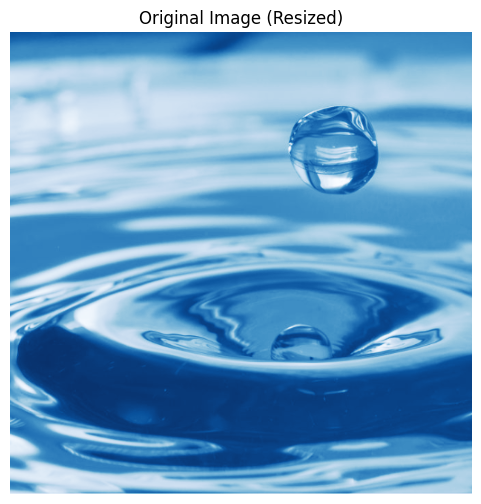

In [32]:
# Load image
img_path = 'Water.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    # Fallback if image not found
    print("Image not found, creating synthetic image")
    x = np.linspace(-10, 10, 256)
    y = np.linspace(-10, 10, 256)
    X, Y = np.meshgrid(x, y)
    img = np.sin(X) * np.cos(Y) * 255
    img = img.astype(np.uint8)

# Crop and resize (256x256 is good for animation speed)
target_size = (512, 512)
width, height = img.shape
min_size = min(width, height)
img_cropped = img[0:min_size, 0:min_size]
img_resized = cv2.resize(img_cropped, target_size)

plt.figure(figsize=(6, 6))
plt.imshow(img_resized, cmap='Blues_r')
plt.title("Original Image (Resized)")
plt.axis('off')
plt.show()

In [33]:
# Compute 2D FFT
f = np.fft.fft2(img_resized)
fshift = np.fft.fftshift(f)

# Get magnitude spectrum for sorting
magnitude = np.abs(fshift)

# Flatten and sort indices by magnitude (descending)
# We want to reconstruct using the most important frequencies first
flat_indices = np.argsort(magnitude.ravel())[::-1]

print(f"Total coefficients: {len(flat_indices)}")

Total coefficients: 262144


In [ ]:
# --- Detailed Animation with Term Visualization (Instagram 9:16 Layout) ---

# Set figure size to 9:16 ratio (e.g., 9x16 inches)
fig, (ax_recon, ax_term) = plt.subplots(2, 1, figsize=(9, 16))

# Adjust layout: Top plot, Middle plot, Space at bottom for text
# bottom=0.2 leaves 20% of the height at the bottom for text
plt.subplots_adjust(top=0.95, bottom=0.2, hspace=0.15, left=0.05, right=0.95)

# Initial plots
im_recon = ax_recon.imshow(np.zeros_like(img_resized), cmap='Blues_r', vmin=0, vmax=255, interpolation='nearest')
ax_recon.set_title("Reconstructed Image", fontsize=32)
ax_recon.axis('off')

im_term = ax_term.imshow(np.zeros_like(img_resized), cmap='Blues_r', interpolation='nearest')
ax_term.set_title(" \nFourier Term (Real Part)", fontsize=32)
ax_term.axis('off')

# Info text placed in the bottom reserved space
info_text = fig.text(0.5, 0.1, "", ha='center', va='center', fontsize=30, 
                     bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.75))

# Reset mask
mask = np.zeros_like(fshift, dtype=bool)
rows, cols = fshift.shape
cy, cx = rows // 2, cols // 2

# Define steps again for better pacing
steps = []
current = 0
# First 30 terms: 1 by 1 (Slow start)
while current < 32:
    steps.append(current)
    current += 2
# Then speed up progressively
while current < len(flat_indices):
    steps.append(current)
    if current < 100:
        current += 4
    elif current < 200:
        current += 10
    elif current < 500:
        current += 20
    elif current < 2000:
        current += 100
    elif current < 10000:
        current += 1000
    else:
        current += 10000
steps.append(len(flat_indices))

def update_detailed(frame_idx):
    start_idx = steps[frame_idx]
    end_idx = steps[frame_idx+1] if frame_idx+1 < len(steps) else len(flat_indices)
    
    # Indices to add in this frame
    batch_indices = flat_indices[start_idx:end_idx]
    
    if len(batch_indices) == 0: return im_recon, im_term, info_text
    
    # Update global mask (Accumulate all terms in this batch)
    y_coords, x_coords = np.unravel_index(batch_indices, (rows, cols))
    mask[y_coords, x_coords] = True
    
    # 1. Reconstruct full image so far
    fshift_masked = fshift * mask
    img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift_masked)))
    im_recon.set_data(img_back)
    
    # 2. Visualize ONLY the strongest term in this batch
    # The batch is sorted, so the first one is the strongest
    idx_max = batch_indices[0] 
    y_max, x_max = np.unravel_index(idx_max, (rows, cols))
    
    # Create a mask for just this ONE term to show its shape
    mask_single = np.zeros_like(fshift, dtype=bool)
    mask_single[y_max, x_max] = True
    
    # Inverse FFT of just this single term
    # We take the real part. Mathematically, the contribution to the real image 
    # comes from the sum of this term and its conjugate symmetric partner.
    # Real(IFFT(single_term)) correctly visualizes this cosine wave.
    fshift_single = fshift * mask_single
    img_single_term = np.real(np.fft.ifft2(np.fft.ifftshift(fshift_single)))
    
    # Scale the visualization to make the wave pattern visible
    # (We normalize it to -1..1 range for display, otherwise it might be too dim or bright)
    im_term.set_data(img_single_term)
    v_range = np.max(np.abs(img_single_term))
    if v_range > 1e-15:
        im_term.set_clim(-v_range, v_range)
    
    # 3. Update Text
    # Get info of the strongest term in this batch
    idx_max = batch_indices[0] # Sorted, so first is largest
    y, x = np.unravel_index(idx_max, (rows, cols))
    ky, kx = y - cy, x - cx
    mag = magnitude.ravel()[idx_max]
    phase = np.angle(fshift[y, x])
    
    text_str = (f"Fourier Term #{start_idx}\n"
                f"Mag: {mag:.1f}, Phase: {phase:.2f} rad\n"
                f"$\propto \cos(2\pi({kx}x/W + {ky}y/H) + {phase:.2f})$")
    
    info_text.set_text(text_str)
    
    return im_recon, im_term, info_text

# Create animation
# interval=100ms (10fps) gives time to read the text
frames = len(steps)-1
anim_detailed = animation.FuncAnimation(fig, update_detailed, frames=frames, interval=100, blit=False)
# Display as HTML5 video
plt.rcParams['animation.embed_limit'] = 5 # Increase limit to 50MB

plt.tight_layout()
plt.close()

In [44]:

mask = np.zeros_like(fshift, dtype=bool)
HTML(anim_detailed.to_jshtml())


Animation size has reached 5383549 bytes, exceeding the limit of 5242880.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [45]:
# ...existing code...
# --- MANUAL MP4 SAVING USING OPENCV (No FFMPEG required) ---
print("Starting manual MP4 generation using OpenCV...")

# Setup Video Writer
output_file = 'fourier_reconstruction_cv2.mp4'
fps = 10
# Get figure dimensions in pixels
fig.canvas.draw()
w, h = fig.canvas.get_width_height()
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(output_file, fourcc, fps, (w, h))

# Reset mask for a fresh run
mask = np.zeros_like(fshift, dtype=bool)

# Loop through all frames manually
total_frames = len(steps) - 1
for i in range(total_frames):
    # Update the plot
    update_detailed(i)
    
    # Draw the canvas to a numpy array
    fig.canvas.draw()
    
    # Convert RGBA buffer to BGR for OpenCV
    img_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_plot = img_plot.reshape((h, w, 3))
    img_bgr = cv2.cvtColor(img_plot, cv2.COLOR_RGB2BGR)
    
    # Write frame
    # Duplicate the first 30 frames 3 times each to slow down the start
    repeat_count = 3 if i < 30 else 1
    for _ in range(repeat_count):
        out.write(img_bgr)
    
    if i % 10 == 0:
        print(f"Processed frame {i}/{total_frames}")

out.release()


Starting manual MP4 generation using OpenCV...
Processed frame 0/107


C:\Users\kaustav\AppData\Local\Temp\ipykernel_49280\3534027452.py:27: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


Processed frame 10/107
Processed frame 20/107
Processed frame 30/107
Processed frame 40/107
Processed frame 50/107
Processed frame 60/107
Processed frame 70/107
Processed frame 80/107
Processed frame 90/107
Processed frame 100/107
